In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import bds
from arch import arch_model
import warnings
import matplotlib.colors as mcolors

warnings.filterwarnings('ignore')

## Step 0
### Data Acquisition

In [2]:
tickers_market = ['SPY']
tickers_energy = ['XLE', 'XOP']
tickers_gold = ['GDX', 'GLD']
tickers_tech = ['IYW', 'XLK']

start = '2017-01-01'
end = '2022-01-01'

data_market = yf.download(tickers_market, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_energy = yf.download(tickers_energy, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_gold = yf.download(tickers_gold, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_tech = yf.download(tickers_tech, start=start, end=end, progress=False, auto_adjust=True)["Close"]  # type: ignore

prices = pd.concat([data_market, data_energy, data_gold, data_tech], axis=1)
rets = pd.DataFrame(np.log(prices / prices.shift(1))).dropna()
rets

Ticker,SPY,XLE,XOP,GDX,GLD,IYW,XLK
Date,,,,,,,
2017-01-04,0.005932,-0.002102,0.004749,0.007326,0.003524,0.004447,0.003478
2017-01-05,-0.000795,-0.002503,-0.003084,0.056753,0.015396,0.001560,0.001633
2017-01-06,0.003571,0.000923,-0.007394,-0.035538,-0.007400,0.009473,0.007314
2017-01-09,-0.003306,-0.014601,-0.028411,0.003121,0.008199,0.002840,-0.000202
2017-01-10,0.000000,-0.009134,0.000000,0.007099,0.004251,0.000324,0.000202
...,...,...,...,...,...,...,...
2021-12-27,0.014053,0.021622,0.039652,0.000958,0.002364,0.020187,0.021226
2021-12-28,-0.000817,-0.000713,-0.008699,-0.007690,-0.004319,-0.008060,-0.005222
2021-12-29,0.001278,-0.006442,-0.004072,0.004173,-0.000297,-0.000431,0.000853


## Step 1
### Foundational Analysis, part A: BDS test on residuals of pairs trading returns

In [3]:

def bds_residuals(ticker1,ticker2):
    # OLS regression and spread
    y = rets[ticker1]
    X = sm.add_constant(rets[ticker2])
    model_energy = sm.OLS(y, X).fit()
    alpha_energy, beta_energy = model_energy.params
    spread_energy = y - (alpha_energy + beta_energy * rets[ticker2])
    spread_energy.name = "Spread"
    print(f"{ticker1} on {ticker2} Regression beta coefficient: ", beta_energy)
    m_vals  = list(range(2,10))
    eps_mul = [0.25* i for i in range(1,8)]
    rows = []
    for m in m_vals:
        for k in eps_mul:
            stats, pvals = bds(y.to_numpy(), max_dim=m, epsilon=k *spread_energy.std())
            z = float(np.atleast_1d(stats)[-1])
            p = float(np.atleast_1d(pvals)[-1])
            rows.append({"m": m, "ε": f"{k:.1f}σ", "z": z, "p": p})
    bds_filt = pd.DataFrame(rows)
    return bds_filt

XLE on XOP Regression beta coefficient:  0.6396327507307803


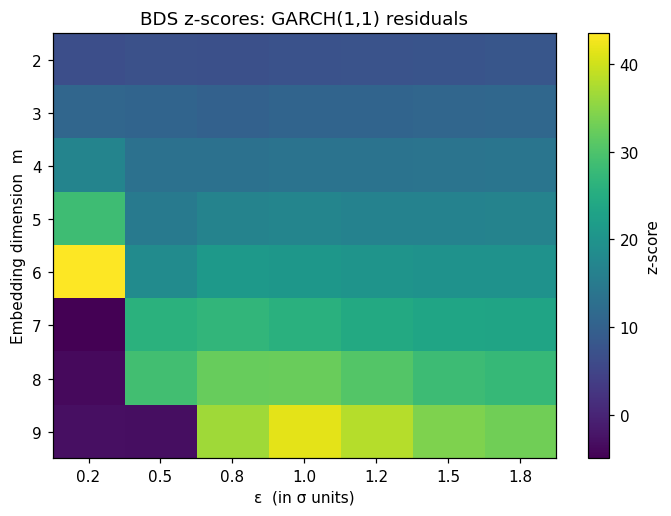

In [4]:

bds_filt = bds_residuals("XLE","XOP")
# Re‑use the two DataFrames that already exist in the notebook
# (bds_raw and bds_filt) and make tidy pivot tables for plotting.

def make_pivot(df: pd.DataFrame, value: str) -> pd.DataFrame:
    """Return a m × epsilon table ready for imshow."""
    tbl = df.copy()
    # strip the trailing 'σ' and cast to float so eps is numeric & sortable
    tbl["eps_float"] = tbl["ε"].str.rstrip("σ").astype(float)
    tbl = tbl.pivot(index="m", columns="eps_float", values=value)
    # ensure natural order (increasing m downward, ε across)
    tbl.sort_index(axis=0, inplace=True)
    tbl.sort_index(axis=1, inplace=True)
    return tbl

filt_piv = make_pivot(bds_filt, "z")

# 2) Heat‑map of z‑scores for GARCH‑filtered residuals
plt.figure(dpi=110)
plt.title("BDS z‑scores: GARCH(1,1) residuals")
plt.imshow(filt_piv, aspect="auto")
plt.xticks(np.arange(len(filt_piv.columns)), filt_piv.columns)
plt.yticks(np.arange(len(filt_piv.index)),   filt_piv.index)
plt.xlabel("ε  (in σ units)")
plt.ylabel("Embedding dimension  m")
plt.colorbar(label="z‑score")
plt.tight_layout()
plt.show()


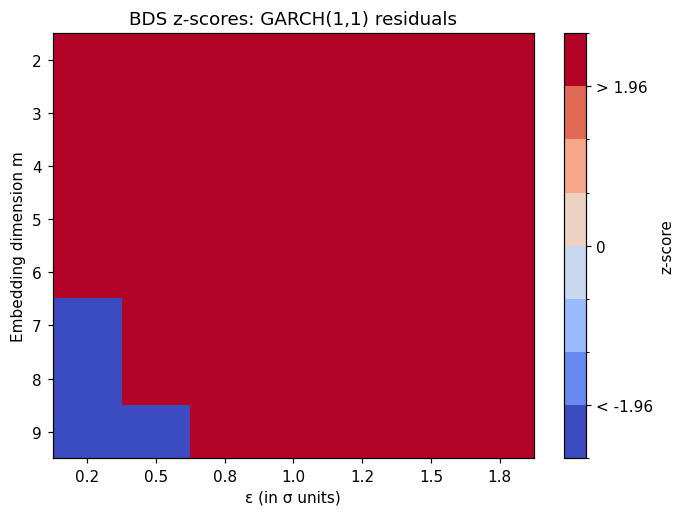

In [5]:

# Define the boundaries for the color normalization
bounds = [-1000, -1.96,-1,-0.5,0,0.5,1, 1.96, 1000]
# Create a custom colormap: red for < -1.96, green for [-1.96, 1.96], blue for > 1.96
num_bounds = len(bounds)
cmap = plt.cm.get_cmap('coolwarm', num_bounds - 1)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N, clip=True)

# 2) Heat-map of z-scores for GARCH-filtered residuals
plt.figure(dpi=110)
plt.title("BDS z-scores: GARCH(1,1) residuals")
plt.imshow(filt_piv, aspect="auto", cmap=cmap, norm=norm)
plt.xticks(np.arange(len(filt_piv.columns)), filt_piv.columns)
plt.yticks(np.arange(len(filt_piv.index)), filt_piv.index)
plt.xlabel("ε (in σ units)")
plt.ylabel("Embedding dimension m")

cbar = plt.colorbar(label="z-score")
# Add custom ticks to the colorbar to indicate the thresholds
cbar.set_ticks([-1.96, 0, 1.96])
cbar.set_ticklabels(['< -1.96', '0', '> 1.96'])

plt.tight_layout()
plt.show()

GOLD

GDX on GLD Regression beta coefficient:  1.9541565472429976


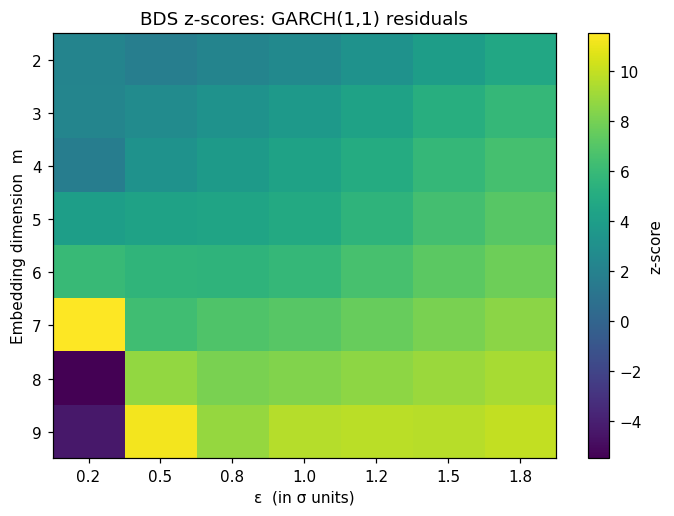

In [6]:
bds_filt = bds_residuals("GDX","GLD")
filt_piv = make_pivot(bds_filt, "z")

# 2) Heat‑map of z‑scores for GARCH‑filtered residuals
plt.figure(dpi=110)
plt.title("BDS z‑scores: GARCH(1,1) residuals")
plt.imshow(filt_piv, aspect="auto")
plt.xticks(np.arange(len(filt_piv.columns)), filt_piv.columns)
plt.yticks(np.arange(len(filt_piv.index)),   filt_piv.index)
plt.xlabel("ε  (in σ units)")
plt.ylabel("Embedding dimension  m")
plt.colorbar(label="z‑score")
plt.tight_layout()
plt.show()

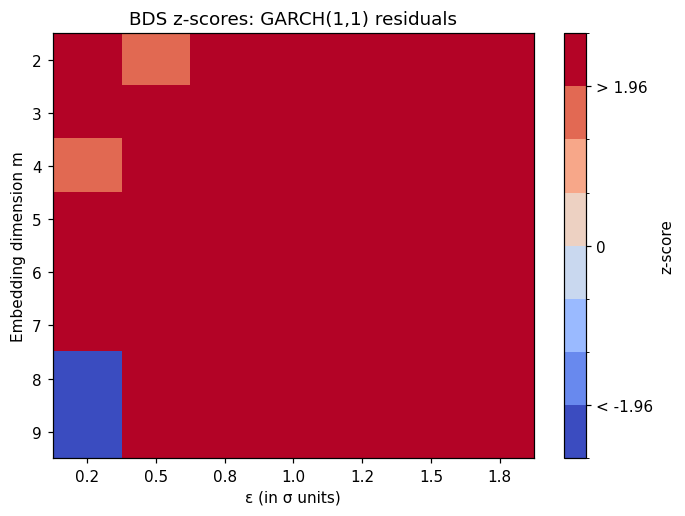

In [7]:
plt.figure(dpi=110)
plt.title("BDS z-scores: GARCH(1,1) residuals")
plt.imshow(filt_piv, aspect="auto", cmap=cmap, norm=norm)
plt.xticks(np.arange(len(filt_piv.columns)), filt_piv.columns)
plt.yticks(np.arange(len(filt_piv.index)), filt_piv.index)
plt.xlabel("ε (in σ units)")
plt.ylabel("Embedding dimension m")

cbar = plt.colorbar(label="z-score")
# Add custom ticks to the colorbar to indicate the thresholds
cbar.set_ticks([-1.96, 0, 1.96])
cbar.set_ticklabels(['< -1.96', '0', '> 1.96'])

plt.tight_layout()
plt.show()

## Tecnhnology

IYW on XLK Regression beta coefficient:  0.9986184658416093


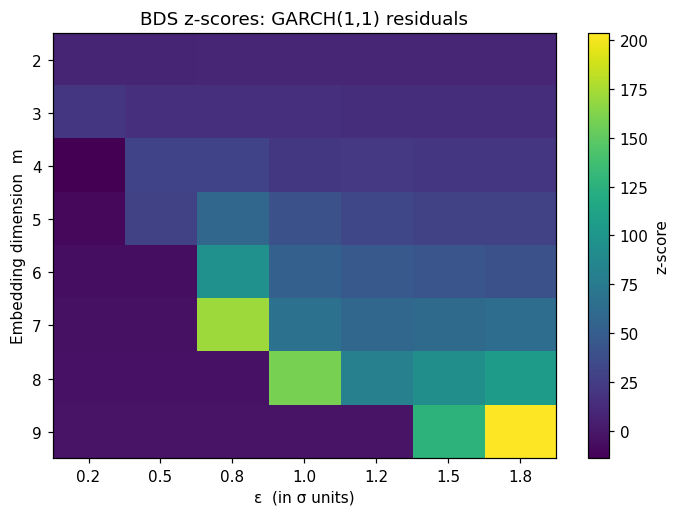

In [8]:
bds_filt = bds_residuals("IYW","XLK")

filt_piv = make_pivot(bds_filt, "z")

# 2) Heat‑map of z‑scores for GARCH‑filtered residuals
plt.figure(dpi=110)
plt.title("BDS z‑scores: GARCH(1,1) residuals")
plt.imshow(filt_piv, aspect="auto")
plt.xticks(np.arange(len(filt_piv.columns)), filt_piv.columns)
plt.yticks(np.arange(len(filt_piv.index)),   filt_piv.index)
plt.xlabel("ε  (in σ units)")
plt.ylabel("Embedding dimension  m")
plt.colorbar(label="z‑score")
plt.tight_layout()
plt.show()

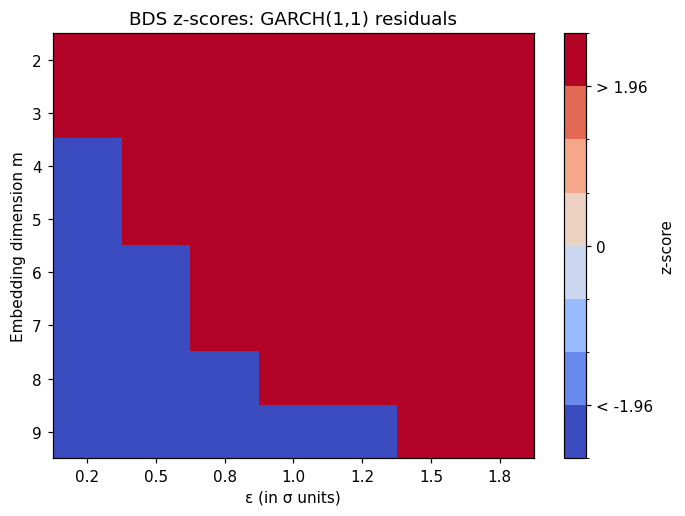

In [9]:
plt.figure(dpi=110)
plt.title("BDS z-scores: GARCH(1,1) residuals")
plt.imshow(filt_piv, aspect="auto", cmap=cmap, norm=norm)
plt.xticks(np.arange(len(filt_piv.columns)), filt_piv.columns)
plt.yticks(np.arange(len(filt_piv.index)), filt_piv.index)
plt.xlabel("ε (in σ units)")
plt.ylabel("Embedding dimension m")

cbar = plt.colorbar(label="z-score")
# Add custom ticks to the colorbar to indicate the thresholds
cbar.set_ticks([-1.96, 0, 1.96])
cbar.set_ticklabels(['< -1.96', '0', '> 1.96'])

plt.tight_layout()
plt.show()

# Removing Volatility clustering

In [10]:
def bds_residuals(ticker1,ticker2):
    # OLS regression and spread
    y = rets[ticker1]
    X = sm.add_constant(rets[ticker2])
    model_energy = sm.OLS(y, X).fit()
    alpha_energy, beta_energy = model_energy.params
    spread_energy = y - (alpha_energy + beta_energy * rets[ticker2])
    spread_energy.name = "Spread"
    print(f"{ticker1} on {ticker2} Regression beta coefficient: ", beta_energy)
    garch = arch_model(100*spread_energy, p=1, q=1, mean="Zero")
    fit = garch.fit(disp="off")
    std_resid = fit.std_resid /100
    m_vals  = list(range(2,10))
    eps_mul = [0.25* i for i in range(1,8)]
    rows = []
    for m in m_vals:
        for k in eps_mul:
            stats, pvals = bds(std_resid.to_numpy(), max_dim=m, epsilon=k *spread_energy.std())
            z = float(np.atleast_1d(stats)[-1])
            p = float(np.atleast_1d(pvals)[-1])
            rows.append({"m": m, "ε": f"{k:.1f}σ", "z": z, "p": p})
    bds_filt = pd.DataFrame(rows)
    return bds_filt

First pair

XLE on XOP Regression beta coefficient:  0.6396327507307803


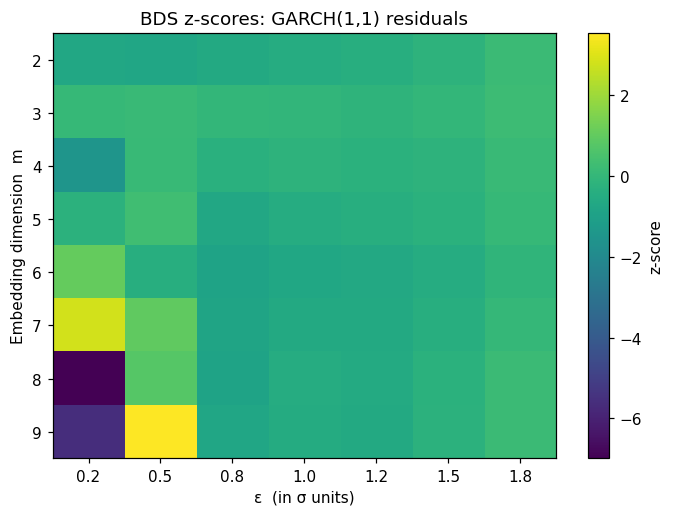

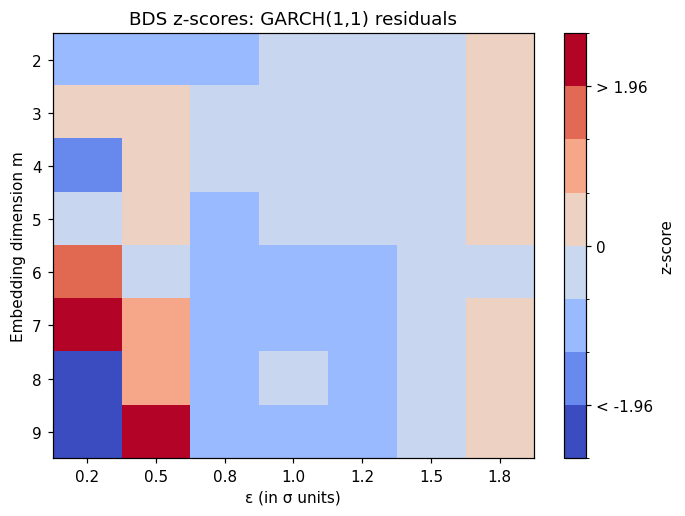

In [11]:
bds_filt = bds_residuals("XLE","XOP")
# Re‑use the two DataFrames that already exist in the notebook
# (bds_raw and bds_filt) and make tidy pivot tables for plotting.

filt_piv = make_pivot(bds_filt, "z")

# 2) Heat‑map of z‑scores for GARCH‑filtered residuals
plt.figure(dpi=110)
plt.title("BDS z‑scores: GARCH(1,1) residuals")
plt.imshow(filt_piv, aspect="auto")
plt.xticks(np.arange(len(filt_piv.columns)), filt_piv.columns)
plt.yticks(np.arange(len(filt_piv.index)),   filt_piv.index)
plt.xlabel("ε  (in σ units)")
plt.ylabel("Embedding dimension  m")
plt.colorbar(label="z‑score")
plt.tight_layout()
plt.show()

# 2) Heat-map of z-scores for GARCH-filtered residuals
plt.figure(dpi=110)
plt.title("BDS z-scores: GARCH(1,1) residuals")
plt.imshow(filt_piv, aspect="auto", cmap=cmap, norm=norm)
plt.xticks(np.arange(len(filt_piv.columns)), filt_piv.columns)
plt.yticks(np.arange(len(filt_piv.index)), filt_piv.index)
plt.xlabel("ε (in σ units)")
plt.ylabel("Embedding dimension m")

cbar = plt.colorbar(label="z-score")
# Add custom ticks to the colorbar to indicate the thresholds
cbar.set_ticks([-1.96, 0, 1.96])
cbar.set_ticklabels(['< -1.96', '0', '> 1.96'])

plt.tight_layout()
plt.show()

Second Pair

GDX on GLD Regression beta coefficient:  1.9541565472429976


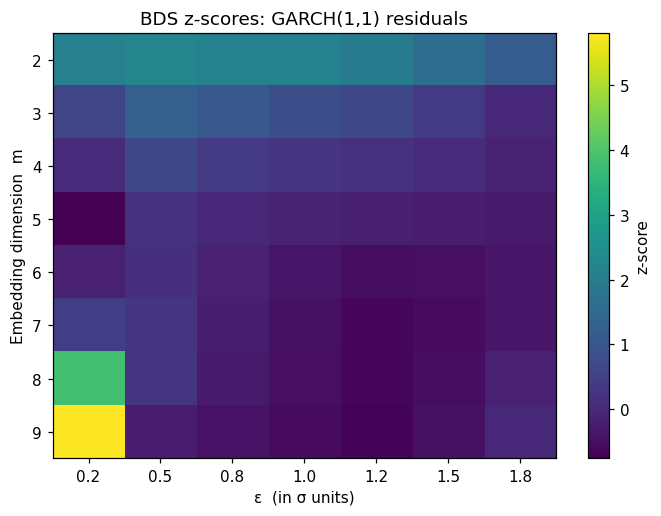

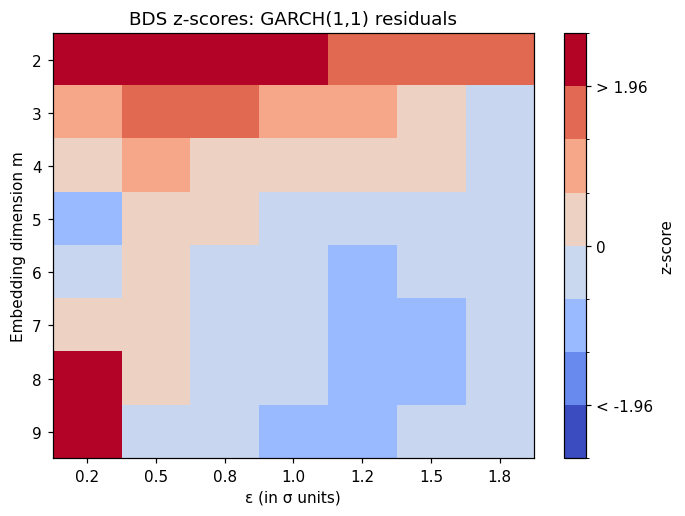

In [12]:
bds_filt = bds_residuals("GDX","GLD")
filt_piv = make_pivot(bds_filt, "z")

# 2) Heat‑map of z‑scores for GARCH‑filtered residuals
plt.figure(dpi=110)
plt.title("BDS z‑scores: GARCH(1,1) residuals")
plt.imshow(filt_piv, aspect="auto")
plt.xticks(np.arange(len(filt_piv.columns)), filt_piv.columns)
plt.yticks(np.arange(len(filt_piv.index)),   filt_piv.index)
plt.xlabel("ε  (in σ units)")
plt.ylabel("Embedding dimension  m")
plt.colorbar(label="z‑score")
plt.tight_layout()
plt.show()

# 2) Heat-map of z-scores for GARCH-filtered residuals
plt.figure(dpi=110)
plt.title("BDS z-scores: GARCH(1,1) residuals")
plt.imshow(filt_piv, aspect="auto", cmap=cmap, norm=norm)
plt.xticks(np.arange(len(filt_piv.columns)), filt_piv.columns)
plt.yticks(np.arange(len(filt_piv.index)), filt_piv.index)
plt.xlabel("ε (in σ units)")
plt.ylabel("Embedding dimension m")

cbar = plt.colorbar(label="z-score")
# Add custom ticks to the colorbar to indicate the thresholds
cbar.set_ticks([-1.96, 0, 1.96])
cbar.set_ticklabels(['< -1.96', '0', '> 1.96'])

plt.tight_layout()
plt.show()

Third pair

IYW on XLK Regression beta coefficient:  0.9986184658416093


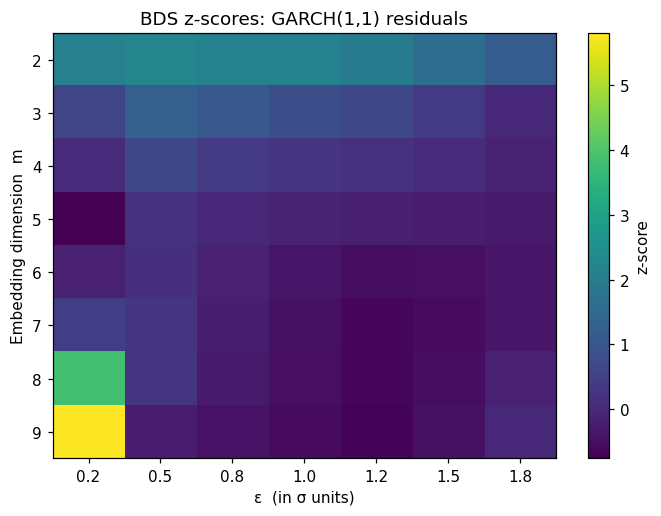

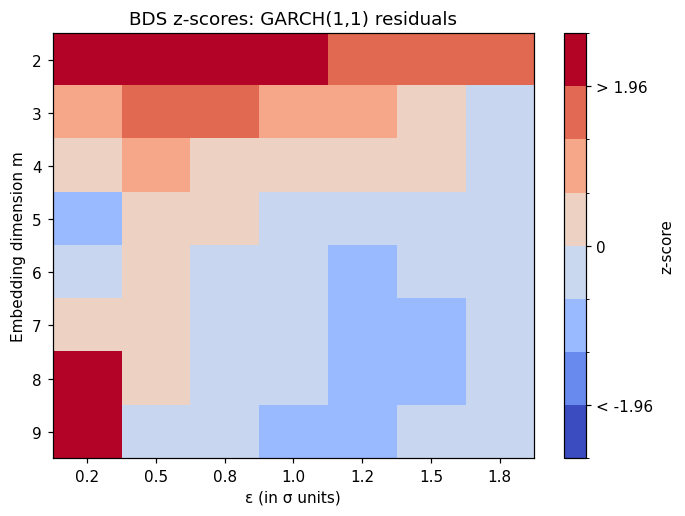

In [13]:
bds_filt = bds_residuals("IYW","XLK")
ilt_piv = make_pivot(bds_filt, "z")

# 2) Heat‑map of z‑scores for GARCH‑filtered residuals
plt.figure(dpi=110)
plt.title("BDS z‑scores: GARCH(1,1) residuals")
plt.imshow(filt_piv, aspect="auto")
plt.xticks(np.arange(len(filt_piv.columns)), filt_piv.columns)
plt.yticks(np.arange(len(filt_piv.index)),   filt_piv.index)
plt.xlabel("ε  (in σ units)")
plt.ylabel("Embedding dimension  m")
plt.colorbar(label="z‑score")
plt.tight_layout()
plt.show()

# 2) Heat-map of z-scores for GARCH-filtered residuals
plt.figure(dpi=110)
plt.title("BDS z-scores: GARCH(1,1) residuals")
plt.imshow(filt_piv, aspect="auto", cmap=cmap, norm=norm)
plt.xticks(np.arange(len(filt_piv.columns)), filt_piv.columns)
plt.yticks(np.arange(len(filt_piv.index)), filt_piv.index)
plt.xlabel("ε (in σ units)")
plt.ylabel("Embedding dimension m")

cbar = plt.colorbar(label="z-score")
# Add custom ticks to the colorbar to indicate the thresholds
cbar.set_ticks([-1.96, 0, 1.96])
cbar.set_ticklabels(['< -1.96', '0', '> 1.96'])

plt.tight_layout()
plt.show()